In [1]:
import dynamics as dn
import numpy as np
import jax
import jax.numpy as jnp
from pykep.core import par2ic, MU_EARTH
import matplotlib.pyplot as plt

%matplotlib inline

## Set reference orbit and satellite initial states

In [2]:
# Parameters
R_EARTH = 6378
MU_EARTH = MU_EARTH * 1e-9

# Initial condition of reference orbit
h = 200  # km  height for perigee
e = 0.001
a = (R_EARTH + h) / (1 - e)
i = 0.6
W = 0
w = 0
E = 0

# satellite initial condition
dr = np.array([0.1, 0.01, 0.01])   # relative position vector to ref
dv = np.array([1e-5, 1e-5, 1e-5])  # relative velocity to ref

### Calculation of other parameters

In [3]:
# compute orbit elements
oe1 = np.array([a, e, i, W, w, E])
r0_1, v0_1 = par2ic(oe1, MU_EARTH)
r0_2, v0_2 = r0_1 + dr, v0_1 + dv
x0_1 = np.hstack([r0_1, v0_1])
x0_2 = np.hstack([r0_2, v0_2])

# convert to jnp array
x0_1 = jnp.array(x0_1)
x0_2 = jnp.array(x0_2)

# create earth to sun vector
earth_to_sun = dn.compute_earth_to_sun()

## Test SRP and drag computation
checked that the order of acceleration matches the figure in the following paper.
https://www.researchgate.net/publication/257934039_Fabrication_of_LTCC_based_Micro_Thrusters_for_Precision_Controlled_Spaceflight

In [4]:

C_D = 1.5
C_SRP = 1.5

A = 1.0   # m^2
m = 100   # kg
gamma_SRP = C_SRP * A/ m
gamma_D = C_D * A / m
psi = 0.0
s0_ref = jnp.hstack([x0_1, gamma_SRP, gamma_D, psi])
s0_sat = jnp.hstack([x0_2, gamma_SRP, gamma_D, psi])
u0 = jnp.zeros(3)
T = 2 * jnp.pi * jnp.sqrt(a**3/MU_EARTH)

print("h: [km]", h)

a_twobody = -MU_EARTH * x0_1[:3]/ jnp.linalg.norm(x0_1[:3]) ** 3
print("Two body [N]: ", m * 1000 * jnp.linalg.norm(a_twobody))

a_srp = dn.solar_radiation_pressure(gamma_SRP, x0_1[:3], earth_to_sun)
print("SRP magnitude [N]: ", m * 1000 * jnp.linalg.norm(a_srp))

a_drag = dn.drag_acceleration(gamma_D, x0_1[:6])
print("drag magnitude [N]: ", m * 1000 * jnp.linalg.norm(a_drag))

h: [km] 200
Two body [N]:  921.1917
SRP magnitude [N]:  6.904776e-06
drag magnitude [N]:  0.019093597


## Test the propagation of absolute orbit

Propagating Absolute Orbit ...


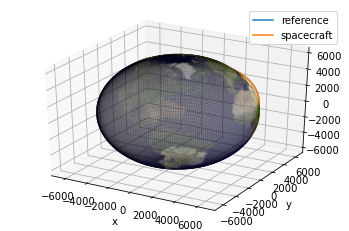

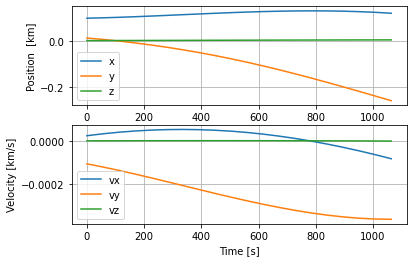

In [5]:
tspan = np.linspace(0, 0.2 * T, 20)   # propagation step
print("Propagating Absolute Orbit ...")

# reference Orbit
s_ref = dn.propagate_absolute_orbit(s0_ref, tspan, dn.zero_control, MU_EARTH,
                                    earth_to_sun, T, pflag=[False, False, False], debug=False)

# Satellite Orbit
s_abs_sat = dn.propagate_absolute_orbit(s0_sat, tspan, dn.zero_control, MU_EARTH,
                                    earth_to_sun, T, pflag=[True, True, True], debug=False)

# Plot the absolute orbit
dn.plot_absolute_orbits(s_ref, s_abs_sat)

# Plot relative orbit from absolute orbit propagation
x_lvlh_from_abs = dn.plot_relative_orbit_from_abs(tspan, s_ref, s_abs_sat)

## Propagate the relative orbit directly
- check that the obtained plot matches the plot obtained from the previous one

Propagating Relative Orbit ...
Step:   1/  20 | x= 1.02e-01  y = 7.64e-03  z= 2.76e-03
Step:   2/  20 | x= 1.04e-01  y = 5.01e-04  z= 2.91e-03
Step:   3/  20 | x= 1.07e-01  y = -7.57e-03  z= 3.08e-03
Step:   4/  20 | x= 1.10e-01  y = -1.66e-02  z= 3.25e-03
Step:   5/  20 | x= 1.13e-01  y = -2.67e-02  z= 3.43e-03
Step:   6/  20 | x= 1.17e-01  y = -3.79e-02  z= 3.61e-03
Step:   7/  20 | x= 1.20e-01  y = -5.01e-02  z= 3.79e-03
Step:   8/  20 | x= 1.23e-01  y = -6.34e-02  z= 3.97e-03
Step:   9/  20 | x= 1.27e-01  y = -7.77e-02  z= 4.16e-03
Step:  10/  20 | x= 1.30e-01  y = -9.31e-02  z= 4.34e-03
Step:  11/  20 | x= 1.33e-01  y = -1.09e-01  z= 4.52e-03
Step:  12/  20 | x= 1.35e-01  y = -1.27e-01  z= 4.69e-03
Step:  13/  20 | x= 1.37e-01  y = -1.45e-01  z= 4.86e-03
Step:  14/  20 | x= 1.38e-01  y = -1.64e-01  z= 5.02e-03
Step:  15/  20 | x= 1.38e-01  y = -1.84e-01  z= 5.17e-03
Step:  16/  20 | x= 1.38e-01  y = -2.04e-01  z= 5.31e-03
Step:  17/  20 | x= 1.37e-01  y = -2.25e-01  z= 5.44e-03
St

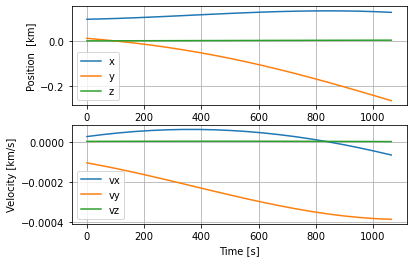

In [6]:
# construct satellite state (Note that we need to include reference orbit as state)
s0_rel_sat = jnp.hstack([dn.eci_to_lvlh(s0_ref, s0_sat), gamma_SRP, gamma_D, psi, s0_ref[:6]])

print("Propagating Relative Orbit ...")
a_rel_total = dn.relative_dynamics(s0_rel_sat, 0, u0, MU_EARTH, earth_to_sun, T, debug=True)
s_rel = dn.propagate_relative_orbit(s0_rel_sat, tspan, dn.zero_control,
                                    MU_EARTH, earth_to_sun, T,
                                    pflag=[True, True, True], debug=True)

# plot the relative orbit
dn.plot_relative_orbit(tspan, s_rel)

## Jacobian computation via JAX
- We can compute the jacobian of the dynamics using JAX foward diff

In [11]:
u = jnp.array([0.001, 0.002, 0.003])
J_abs = jax.jacfwd(dn.absolute_dynamics, argnums=(0,2))(s0_ref, 0, u, MU_EARTH, earth_to_sun, T, debug=True)
print("Jacobian (x, absolute orbit): ", J_abs[0])
print("Jacobian (u, absolute orbit): ", J_abs[1])

J_rel = jax.jacfwd(dn.relative_dynamics, argnums=(0,2))(s0_rel_sat, 0, u, MU_EARTH, earth_to_sun, T, debug=True)
print("Jacobian (x, relative orbit): ", J_rel[0])
print("Jacobian (u, relative orbit): ", J_rel[1])

Total Acceleration: Traced<ConcreteArray(0.008968518115580082, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.00896852, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
    val = DeviceArray([-2.56327371e-06, -3.12271794e-07, -4.68427004e-07,
              2.13501785e-08, -1.24325465e-08, -1.24042794e-08,
              1.79397708e-09, -4.68091685e-06,  5.74328878e-04,
             -9.15638089e-01,  2.22984329e-01,  3.34492028e-01],            dtype=float32)
    batch_dim = 0
Jacobian (x, absolute orbit):  [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00